In [1]:
import pandas as pd
import numpy as np

In [2]:
import sys
if '' not in sys.path:
  sys.path.append('.')

from kalman import Kalman

In [3]:
from typing import Callable, Optional, Tuple

# test on 2d state space
def generate_zt_true(
    rng: np.random.Generator, T: int, n_dim_z: int,
    f_zt: Callable, z0_params: Tuple[np.ndarray, np.ndarray], 
    Q: np.ndarray,
    f_ut: Optional[Callable] = None, ut: Optional[np.ndarray] = None,
  ):
  zt = np.zeros((n_dim_z, T+1), dtype=np.float32)
  z0 = rng.multivariate_normal(z0_params[0], z0_params[1])
  zt[:,0] = z0
  wt = rng.multivariate_normal(np.zeros(Q.shape[0]), Q, T).T
  for t in range(1, T+1):
    zt[:,t] = f_zt(zt[:, t-1], t) + wt[:,t-1]
    if f_ut is not None:
      zt[:,t] += f_ut(ut, t)
  return zt

def generate_yt(
    rng: np.random.Generator, zt: np.ndarray, n_dim_y: int,
    f_zt_out: Callable, 
    R: np.ndarray,
    f_ut_out: Optional[Callable] = None, ut: Optional[np.ndarray] = None,
  ):
  T = zt.shape[1] - 1
  yt = np.zeros((n_dim_y, T), dtype=np.float32)
  vt = rng.multivariate_normal(np.zeros(R.shape[0]), R, T).T
  for t in range(1, T+1):
    yt[:,t-1] = f_zt_out(zt[:, t], t) + vt[:,t-1]
    if f_ut_out is not None:
      yt[:,t-1] += f_ut_out(ut, t)
  return yt

In [4]:
# define the state space model (newtonian motion, state is position and velocity, no control, observation is position)
A = np.array([[1, 1], [0, 1]], dtype=np.float32)
C = np.array([[1, 0]], dtype=np.float32)
Q = np.array([[0.01, 0], [0, 0.1]], dtype=np.float32)
R = np.array([[16]], dtype=np.float32)

f_zt = lambda zt, t: A @ zt
f_zt_out = lambda zt, t: C @ zt

T = 20
rng = np.random.default_rng(0)

z0_params = (np.array([0, 0.3], dtype=np.float32), np.array([[0.5, 0], [0, 2]], dtype=np.float32))

zt: (2, 21) yt: (1, 20)


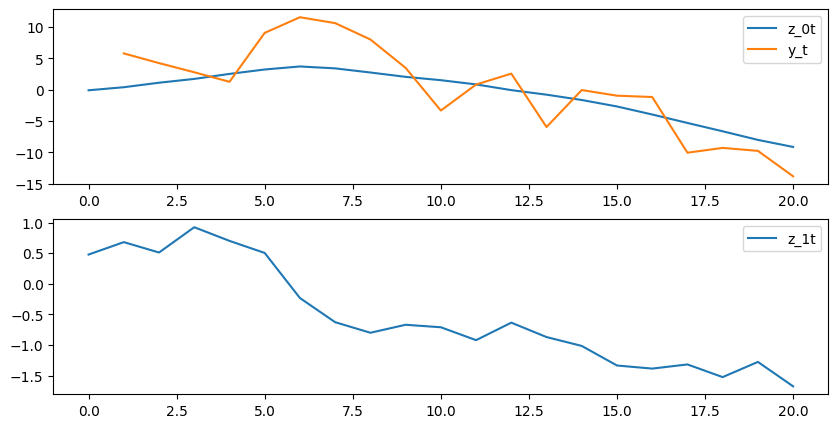

In [5]:
# generate and plot zt and yt
import matplotlib.pyplot as plt

zt = generate_zt_true(rng, T, 2, f_zt, z0_params, Q)
yt = generate_yt(rng, zt, 1, f_zt_out, R)
print('zt:', zt.shape, 'yt:', yt.shape)


fig, ax = plt.subplots(2, 1, figsize=(10, 5))

# plot true position and observed position (shifted by 1)
ax[0].plot(zt[0,:], label='z_0t')
ax[0].plot(np.arange(1, T+1), yt[0,:], label='y_t')
ax[0].legend()

# plot true velocity
ax[1].plot(zt[1,:], label='z_1t')
ax[1].legend()

plt.show()

In [6]:
kalman_filt = Kalman(A, C, Q, R, z0_params[0], z0_params[1], yt)

filtered_zt (2, 21) filtered_Pt (2, 2, 21)


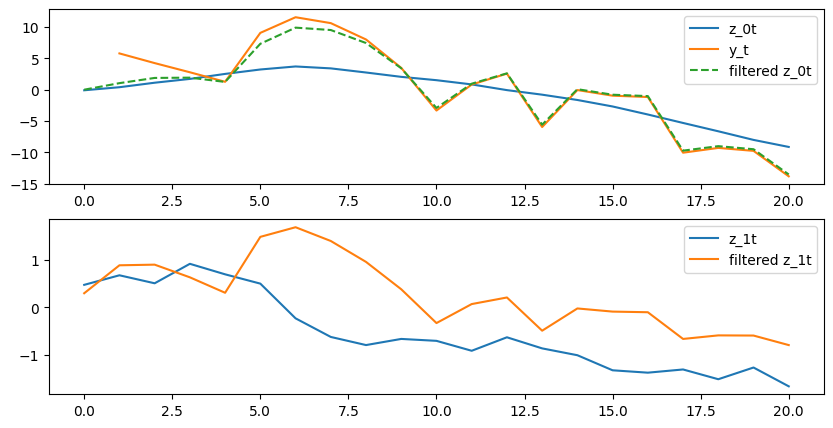

In [7]:
filtered_zt, filtered_Pt = kalman_filt.filter()
print('filtered_zt', filtered_zt.shape, 'filtered_Pt', filtered_Pt.shape)

# plot filtered position and velocity
fig, ax = plt.subplots(2, 1, figsize=(10, 5))

# plot true position, observed position and filtered position
ax[0].plot(zt[0,:], label='z_0t')
ax[0].plot(np.arange(1, T+1), yt[0,:], label='y_t')
ax[0].plot(filtered_zt[0,:], label='filtered z_0t', linestyle='--')
ax[0].legend()

# plot true velocity and filtered velocity
ax[1].plot(zt[1,:], label='z_1t')
ax[1].plot(filtered_zt[1,:], label='filtered z_1t')
ax[1].legend()

plt.show()


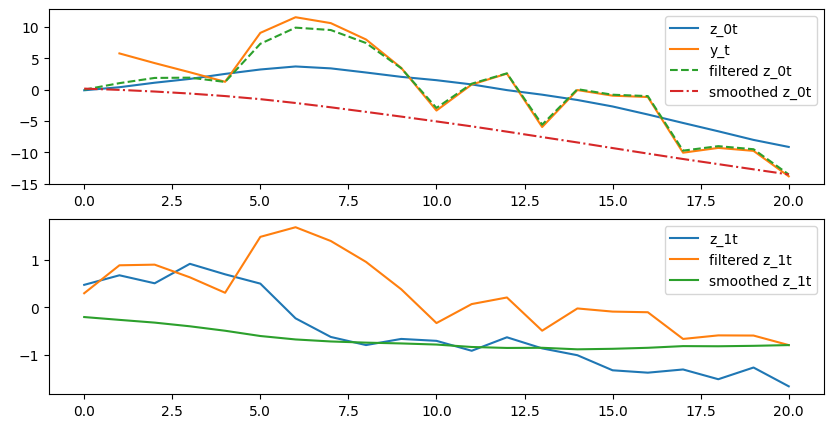

In [9]:
# smoothen the data
smoothed_zt, smoothed_Pt, smoothed_Ptt1 = kalman_filt.smooth()

# plot smoothened position and velocity
fig, ax = plt.subplots(2, 1, figsize=(10, 5))

# plot true position, observed position, filtered position and smoothened position
ax[0].plot(zt[0,:], label='z_0t')
ax[0].plot(np.arange(1, T+1), yt[0,:], label='y_t')
ax[0].plot(filtered_zt[0,:], label='filtered z_0t', linestyle='--')
ax[0].plot(smoothed_zt[0,:], label='smoothed z_0t', linestyle='-.')
ax[0].legend()

# plot true velocity, filtered velocity and smoothened velocity
ax[1].plot(zt[1,:], label='z_1t')
ax[1].plot(filtered_zt[1,:], label='filtered z_1t')
ax[1].plot(smoothed_zt[1,:], label='smoothed z_1t')
ax[1].legend()

plt.show()